# PPO with Technical Analysis - GME

Import the dependencies

In [1]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 quantstats stable-baselines3 gym-anytrading gym finta alpha_vantage  

Importing libraries, for environment, technical analysis, reinforcement learning and data processing

In [2]:
# Enviroment
import gym
import gym_anytrading

#Technical Analysis
from gym_anytrading.envs import StocksEnv
from finta import TA
import quantstats as qs

# Stable baselines - Reinforcement learning
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO

# Data Processing
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

# 1. Data

Collate data from alpha vantage

In [3]:
ts = TimeSeries(key='ADRTS42HSSQR2GQ2', output_format='pandas')
data, meta_data = ts.get_daily(symbol='GME', outputsize='full')

Rename columns

In [4]:
data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

Order date in ascending order

In [5]:
df = data
df.sort_values('date', ascending=True, inplace=True)

Used to give timeframe for testing (start - 30/11/2020) and train (01/12/2020 - 30/6/2021)

In [6]:
window = 36
start = window
train = len(df) - 190
test = len(df) - 189
end = len(df) - 20

# 2. Environment

Make the stocks environment

In [7]:
env = gym.make('stocks-v0', df=df, frame_bound=(window, end), window_size=window)

Workaround for MACD SIGNALS as df did not support it

In [8]:
def appendData(maindf, dataarray, namesarray=None):
    if namesarray==None:
        return maindf.join(pd.DataFrame(dataarray), how='outer')
    return maindf.join(pd.DataFrame(dataarray,columns=namesarray), how='outer')

Calculate techniques for technical analysis on data frame, where answer gives n/a inplace put 0

In [9]:
df['EMA'] = TA.EMA(df, 12)
df['VWAP'] = TA.VWAP(df)
df['RSI'] = TA.RSI(df)
df = appendData(df, TA.MACD(df)).rename(columns={"SIGNAL": "MACD SIGNAL"})
df.fillna(0, inplace=True)

Add the custom signals to the environment

In [10]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume', 'EMA', 'VWAP', 'RSI', 'MACD SIGNAL']].to_numpy()[start:end]
    return prices, signal_features

Pass custom signals to main stock environment

In [11]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df, window_size=window, frame_bound=(window,train))

# 3. Training

Train the agent on the environment

In [12]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [ ]:
model = PPO('MlpPolicy', env) 
model.learn(total_timesteps=10000)

# 4. Evaluation

Test the agent on an untrained time period

In [ ]:
env = MyCustomEnv(df=df, window_size=window, frame_bound=(test,end))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

Here we add in quantstats for a breakdown of the testing period to perform analysis on the quantitative statistics 

In [15]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[test+1:end])
returns = net_worth.pct_change().iloc[1:]

qs.reports.metrics(returns, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2020-12-01
End Period                 2021-07-30
Risk-Free Rate             0.0%
Time in Market             23.0%

Cumulative Return          288.26%
CAGR%                      680.27%

Sharpe                     1.71
Sortino                    5.32
Sortino/√2                 3.76

Max Drawdown               -39.99%
Longest DD Days            128
Volatility (ann.)          217.33%
Calmar                     17.01
Skew                       5.69
Kurtosis                   43.52

Expected Daily %           0.82%
Expected Monthly %         18.48%
Expected Yearly %          97.04%
Kelly Criterion            26.7%
Risk of Ruin               0.0%
Daily Value-at-Risk        -21.04%
Expected Shortfall (cVaR)  -21.04%

Gain/Pain Ratio            1.39
Gain/Pain (1M)             3.18

Payoff Ratio               2.81
Profit Factor              2.39
Common Sense Ratio         3.44
CPC Index         

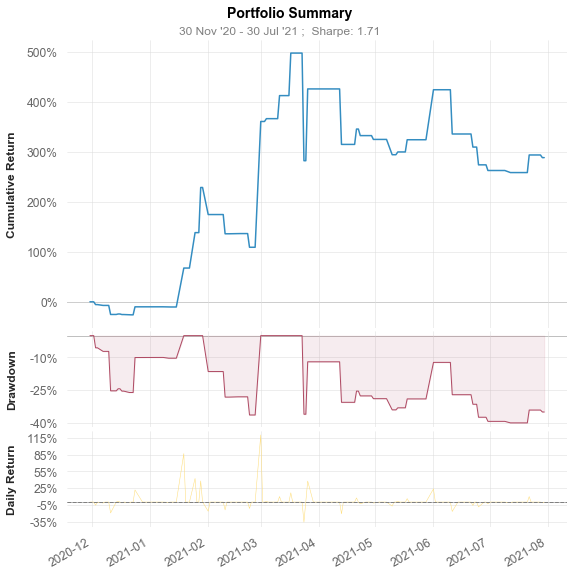

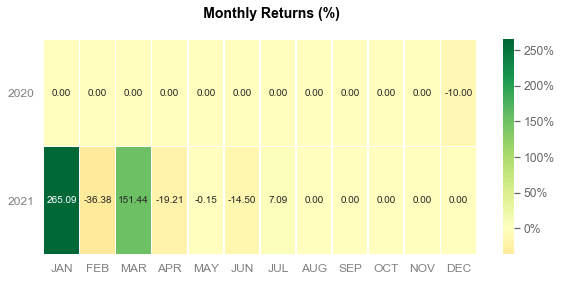

In [16]:
qs.reports.plots(returns, mode='basic')